In [1]:
import pandas as pd
import geopandas as gpd
from shapely import wkt
import matplotlib.pyplot as plt
import statsmodels.api as sm
import sys
import os
sys.path.append(os.path.abspath(".."))
from utils import *

In [2]:
year = 2023
rating_data_path = '/share/garg/311_data/sb2377_a_data/parks/Parks_Inspection_Program___Inspections_20240316.csv'
report_data_path = '/share/garg/311_data/sb2377/data_{}.csv'.format(year)
preprocessed_report_data_path = '/share/garg/311_data/sb2377/processed_maintenance_or_facility_{}.csv'.format(year)
covars_path = '/share/garg/311_data/sb2377/tract_demographics.csv'
all_parks_path = '/share/garg/311_data/sb2377_a_data/parks/Parks_Inspection_Program___All_Sites__MAPPED__20240316.csv'
save_path = '/share/garg/311_data/sb2377/processed_parks_{}.csv'.format(year)

In [3]:
complaint_type = 'Maintenance or Facility'
reported_label = 'reported'
heuristic_distance_cutoff = 50
inspection_indicator = 'has_inspection_{}'.format(heuristic_distance_cutoff)
rename_map = {'Date': 'date', 
              'Multipolygon': 'finegrained_geometry',
              'Prop ID': 'finegrained_id'
             }

In [4]:
covariates_arr = pd.read_csv(covars_path)
parks_df = pd.read_csv(all_parks_path)
df = pd.read_csv(rating_data_path)
if os.path.exists(preprocessed_report_data_path):
    reports_df = pd.read_csv(preprocessed_report_data_path)
else:
    df_311 = pd.read_csv(report_data_path)

In [5]:
reports_df = reports_df.rename(columns=rename_map)

reports_df['Created Date'] = pd.to_datetime(reports_df['Created Date'])
reports_df['month'] = reports_df['Created Date'].dt.month
reports_df.loc[(reports_df['month'] == 1) & (reports_df['week'] > 50), 'week'] = 0

In [6]:
census_gdf, final_graph, census_gdf_raw = generate_graph_census()
census_gdf = census_gdf.to_crs('EPSG:2263')

Using the default year of 2021
Using FIPS code '36' for input 'NY'
Using FIPS code '061' for input 'New York'
Using FIPS code '005' for input 'Bronx'
Using FIPS code '047' for input 'Kings'
Using FIPS code '081' for input 'Queens'
Using FIPS code '085' for input 'Richmond'


In [7]:
# process list of all parks
# rename columns
parks_df = parks_df.rename(columns=rename_map)
parks_df['finegrained_geometry'] = parks_df['finegrained_geometry'].apply(wkt.loads)

# get census tract information
parks_df = gpd.GeoDataFrame(parks_df,
                            geometry=parks_df['finegrained_geometry'],
                            crs='EPSG:4326')
parks_sjoin = gpd.sjoin(parks_df.to_crs('EPSG:2263').reset_index(drop=True),census_gdf.to_crs('EPSG:2263'), how='inner', op='intersects')
parks_sjoin = parks_sjoin.drop(columns='geometry')
parks_sjoin = pd.merge(parks_sjoin, census_gdf[['GEOID', 'geometry']], on='GEOID', how='left')
parks_sjoin = parks_sjoin.drop(columns='index_right')
parks_sjoin['intersection_area'] = parks_sjoin.apply(lambda row: row['geometry'].intersection(row['finegrained_geometry']).area, axis=1)
parks_df = parks_sjoin.loc[parks_sjoin.groupby('finegrained_id')['intersection_area'].idxmax()]
parks_df = gpd.GeoDataFrame(parks_df,
                            geometry=parks_df['finegrained_geometry'],
                            crs='EPSG:4326')
parks_df = parks_df.to_crs('EPSG:2263')

/share/pierson/conda_virtualenvs/networks_underreporting_env/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3338: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


In [8]:
# process rating data
# rename columns
df = df.rename(columns=rename_map)

# process date
df['date'] = pd.to_datetime(df['date'], format='%m/%d/%Y %I:%M:%S %p')
df['year'] = df['date'].dt.year
df['week'] = df['date'].dt.isocalendar().week
df['month'] = df['date'].dt.month
df.loc[(df['month'] == 1) & (df['week'] > 50), 'week'] = 0 # start first week at 0 (instead of previous year's indexing)
one_year_df = df[df['year'] == year]

# add location information
one_year_df = pd.merge(one_year_df, parks_df, on='finegrained_id', how='left')

# subset to data with at least one score
one_year_df = one_year_df[(one_year_df['Overall Condition'].isin(['U', 'A'])) & (one_year_df['Cleanliness'].isin(['U', 'A']))]

# convert binary ratings to scores
one_year_df['condition_score'] = 0
one_year_df.loc[one_year_df['Overall Condition'] != 'U', 'condition_score'] = 1
one_year_df['cleanliness_score'] = 0
one_year_df.loc[one_year_df['Cleanliness'] != 'U', 'cleanliness_score'] = 1
one_year_df['score'] = one_year_df['condition_score'] + one_year_df['cleanliness_score']
one_year_df = one_year_df[['finegrained_id', 'date', 'week', 'GEOID', 'score']]
one_year_df = one_year_df.dropna() # remove rows that did not match into any census tract
one_year_df = one_year_df.groupby(['finegrained_id', 'week', 'GEOID', 'date'])['score'].mean().reset_index()

rating_df = one_year_df

In [9]:
# process reporting data
if not os.path.exists(preprocessed_report_data_path):
    # get data for type
    type_df = df_311[df_311['Complaint Type'] == complaint_type]
    type_df['Created Date'] = pd.to_datetime(type_df['Created Date'])
    type_df['week'] = type_df['Created Date'].dt.isocalendar().week
    type_df['month'] = type_df['Created Date'].dt.month
    type_df.loc[(type_df['month'] == 1) & (type_df['week'] > 50), 'week'] = 0 # start first week at 0 (instead of previous year's indexing)

    # process location
    type_df = type_df[~(type_df.Latitude.isna()|type_df.Longitude.isna())]
    type_gdf = gpd.GeoDataFrame(type_df,
                                geometry=gpd.points_from_xy(type_df.Longitude, type_df.Latitude),
                                crs='EPSG:4326')

    # get census tract information
    type_gdf = gpd.sjoin(type_gdf.to_crs('EPSG:2263').reset_index(drop=True), census_gdf.to_crs('EPSG:2263'), how='inner', op='intersects')
    type_gdf['GEOID'] = type_gdf['GEOID'].astype(int)
    type_gdf = type_gdf.to_crs('EPSG:2263')

    reports_df = type_gdf

In [10]:
# match each complaint with its associated street
# loop through tract by tract and complete the matching within each tract to lower complexity
if not os.path.exists(preprocessed_report_data_path):
    all_distances = []
    for tract_geoid in reports_df['GEOID'].unique():
        # get all ratings and reports from this tract
        tract_park_df = parks_df[parks_df['GEOID'] == tract_geoid].copy()
        tract_reports_df = reports_df[reports_df['GEOID'] == tract_geoid].copy()

        finegrained_ids = tract_park_df[['finegrained_id', 'finegrained_geometry']].copy()
        report_locations = tract_reports_df[['Unique Key', 'geometry']].copy()

        if len(finegrained_ids) > 0:
            # Cross join street_ids and report_locations to create a DataFrame with all possible pairs of finegrained geometries and report points
            finegrained_ids['key'] = 1
            report_locations['key'] = 1
            cross_joined_df = pd.merge(finegrained_ids, report_locations, on='key').drop(labels='key', axis=1)

            # Calculate the distance for each pair
            cross_joined_df['distance'] = cross_joined_df.apply(lambda row: row['finegrained_geometry'].distance(row['geometry']), axis=1)

            # Finding the minimum distance for each point
            min_distances = cross_joined_df.loc[cross_joined_df.groupby('Unique Key')['distance'].idxmin()]
            all_distances.append(min_distances)
        else:
            # if there are no streets in this tract, search across all streets (across all census tracts)
            finegrained_ids = parks_df[['finegrained_id', 'finegrained_geometry']].copy()

            # Cross join street_ids and report_locations to create a DataFrame with all possible pairs of finegrained geometries and report points
            finegrained_ids['key'] = 1
            report_locations['key'] = 1
            cross_joined_df = pd.merge(finegrained_ids, report_locations, on='key').drop(labels='key', axis=1)

            # Calculate the distance for each pair
            cross_joined_df['distance'] = cross_joined_df.apply(lambda row: row['finegrained_geometry'].distance(row['geometry']), axis=1)

            # Finding the minimum distance for each point
            min_distances = cross_joined_df.loc[cross_joined_df.groupby('Unique Key')['distance'].idxmin()]
            all_distances.append(min_distances)

    # combine data across all census tracts
    all_min_distances = pd.concat(all_distances)

    # merge reports data with nearest inspection
    reports_df = pd.merge(reports_df, all_min_distances[['finegrained_id', 'finegrained_geometry', 'Unique Key', 'distance']], on='Unique Key')

Text(0, 0.5, 'Percentage of dataset with\nclosest finegrained entity < cutoff')

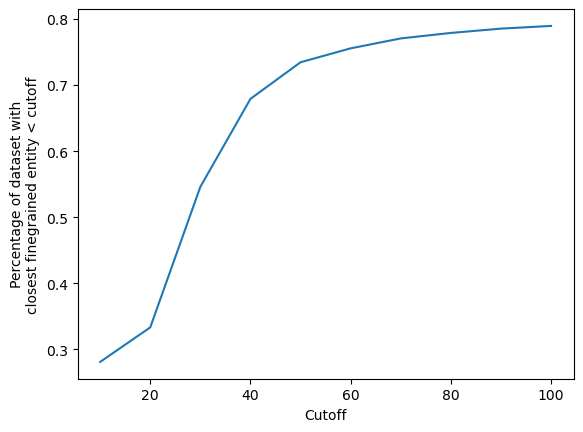

In [11]:
# heuristic: we only keep reports that are within CUTOFF distance to a rating inspection
cutoffs = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
pcts = []
for c in cutoffs:
    label = 'has_inspection_{}'.format(c)
    reports_df[label] = 0
    reports_df.loc[reports_df['distance'] < c, label] = 1
    pcts.append(reports_df[label].mean())
    
# apply distance heuristic
inspected_reports_df = reports_df[reports_df[inspection_indicator] == 1]

# remove rows for which the park didn't receive an inspection
inspected_reports_df = inspected_reports_df[inspected_reports_df['finegrained_id'].isin(rating_df['finegrained_id'].unique())]

# visualize percentage of reports kept across different cutoffs 
plt.plot(cutoffs, pcts)
plt.xlabel('Cutoff')
plt.ylabel('Percentage of dataset with\nclosest finegrained entity < cutoff')

In [12]:
# create num finegrained entities x num weeks full T and r dataset
finegrained_entities = rating_df['finegrained_id'].unique()

dfs = []
for i in sorted(reports_df['week'].unique()):
    data = pd.DataFrame()
    data['finegrained_id'] = finegrained_entities
    data['report_week'] = i
    dfs.append(data)
    
all_data = pd.concat(dfs)

# add in T labels
# set T = 1 for instances where there is a complaint
inspected_reports_df['report_week'] = inspected_reports_df['week']
inspected_reports_df = inspected_reports_df[['finegrained_id', 'report_week']].drop_duplicates()
inspected_reports_df['reported'] = 1
all_data = pd.merge(all_data, inspected_reports_df, on=['finegrained_id', 'report_week'], how='left')
all_data['reported'] = all_data['reported'].fillna(0)

# add in rating data
rating_df['rating_week'] = rating_df['week']
rating_df['report_week'] = rating_df['week']
rating_subset_df = rating_df[['finegrained_id', 'score', 'rating_week', 'report_week']].drop_duplicates()
all_data = pd.merge(all_data, rating_subset_df, on=['finegrained_id', 'report_week'], how='left')

# assume constant rating until next inspection 
all_data.sort_values(by=['finegrained_id', 'report_week'], inplace=True)
all_data['score'] = all_data.groupby('finegrained_id')['score'].ffill()
all_data['rating_week'] = all_data.groupby('finegrained_id')['rating_week'].ffill()
all_data = all_data[::-1]
all_data['score'] = all_data.groupby('finegrained_id')['score'].ffill()
all_data['rating_week'] = all_data.groupby('finegrained_id')['rating_week'].ffill()
all_data = all_data[::-1]

# add in demographic data
all_data = pd.merge(all_data, rating_df[['finegrained_id', 'GEOID']].drop_duplicates(), on=['finegrained_id'], how='left')
all_data['GEOID'] = all_data['GEOID'].astype(int)
all_data = pd.merge(all_data, covariates_arr, on=['GEOID'], how='left')

# add in meta data
all_data['rating_week_of_year'] = all_data['rating_week']
all_data['report_week_of_year'] = all_data['report_week']

# get z-scored ratings
all_data['normalized_score'] = (all_data['score'] - all_data['score'].mean()) / all_data['score'].std()

In [13]:
assert(len(finegrained_entities) * len(inspected_reports_df['report_week'].unique()) == len(all_data))

In [14]:
len(all_data)

169706

In [16]:
all_data.to_csv(save_path)

In [15]:
# evaluate mean rating with and without a report
mean_1 = all_data[(all_data[reported_label] == 1)]['score'].mean()
error_1 = all_data[(all_data[reported_label] == 1)]['score'].std() / len(all_data)
mean_0 = all_data[(all_data[reported_label] == 0)]['score'].mean()
error_0 = all_data[(all_data[reported_label] == 0)]['score'].std() / len(all_data)
print('Mean rating of tracts with a report = {}, without a report = {}'.format(mean_1, mean_0))
print('95% CIs rating of tracts with a report = [{}, {}], without a report = [{}, {}]'.format(mean_1 - 1.96 * error_1, mean_1 + 1.96 * error_1, mean_0 - 1.96 * error_0, mean_0 + 1.96 * error_0))

Mean rating of tracts with a report = 1.7493403693931397, without a report = 1.8376726869942464
95% CIs rating of tracts with a report = [1.749333288282099, 1.7493474505041804], without a report = [1.8376671271701355, 1.8376782468183572]


Optimization terminated successfully.
         Current function value: 0.172244
         Iterations 8


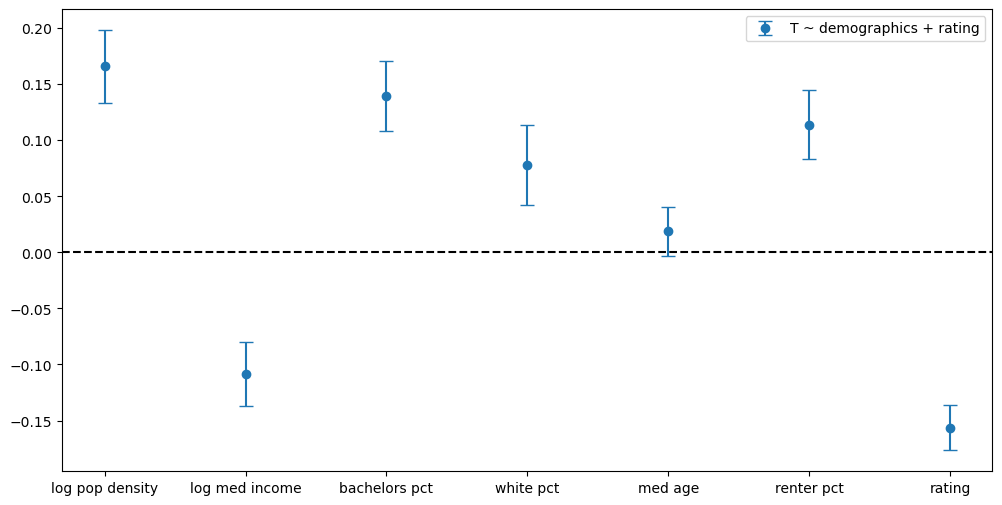

In [16]:
# run a regression of T ~ demographics + rating
covariates = ['log pop density',
              'log med income',
              'bachelors pct',
              'white pct',
              'med age',
              'renter pct'
             ]

normalized_covariates = ['normalized_log_population_density',
                         'normalized_log_income_median',
                         'normalized_education_bachelors_pct',
                         'normalized_race_white_nh_pct',
                         'normalized_age_median',
                         'normalized_households_renteroccupied_pct',
                         'normalized_score'
                        ]

plt.figure(figsize=(12, 6))

y_label = reported_label
formula = y_label + ' ~ '
for c in normalized_covariates:
    formula += c + ' + '
formula = formula[:-3]

fit = sm.Logit.from_formula(formula, data = all_data).fit()
fit.summary()
coefficients = fit.params.to_numpy()[-7:]
conf_intervals = fit.conf_int().to_numpy()[-7:, :]
plt.errorbar(x=covariates + ['rating'], y=coefficients, 
             yerr=[coefficients - conf_intervals[:,0], conf_intervals[:,1] - coefficients], capsize=5, fmt='o', label='T ~ demographics + rating')

plt.axhline(0, color='black', linestyle='--')  # Horizontal dashed line at y=0
plt.legend()
plt.show()